# read preprocessing

In [ ]:
# read trimming
! mkdir Tn5_20240715/untrimmed_reads/Trimmed
! for input in Tn5_20240715/untrimmed_reads/P3*.fastq.gz; do out=Tn5_20240715/untrimmed_reads/Trimmed/$(echo $input | sed 's/fastq\.gz/fastq/'); cutadapt --trim-n -q 20 -m 20 -a CTGTCTCTTATACACATCT -o $out $input; done

! mkdir ssDNA_20240706/untrimmed_reads/Trimmed
! for input in ssDNA_20240706/untrimmed_reads/P9*_R2_001.fastq.gz; do out=Trimmed/$(echo $input | sed 's/fastq\.gz/fastq/'); cutadapt --trim-n -q 20 -m 20 -g ^TTTTTTTTTT -a ACTGTCTCTTATACACATCT -o $out $input; done

# read mapping
! cd Tn5_20240715/sam/
! bwa index references_masked.fasta
! for i in {1..5}; do bwa mem references_masked.fasta ../untrimmed_reads/Trimmed/P3_H"$i"*.fastq > P3_H"$i"_masked.sam; done

! cd ssDNA_20240706/sam/
! bwa index references_w_spike.fasta
! for i in {1..8}; do bwa mem references_w_spike.fasta ../untrimmed_reads/Trimmed/P9_D"$i"*.fastq > D"$i"_masked.sam; done

# read analysis (in python)

In [7]:
# Run in bioconda environment

#Import helpful packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['axes.linewidth'] = 0.5
matplotlib.rcParams['xtick.major.width'] = 0.5
matplotlib.rcParams['ytick.major.width'] = 0.5

matplotlib.rcParams['patch.force_edgecolor'] = True
matplotlib.rcParams['patch.linewidth'] = 0.5


#Packages for sequence parsing
from Bio import SeqIO
from Bio.Seq import Seq
from collections import Counter
import pysam


#Some useful colors and custom colormaps

darkgrey = "#737880"
midgrey = "#949598"
lightgrey = "#C8CECE"
lightestgrey = "#DBDAD5"
greypalette = [darkgrey, midgrey, lightgrey, lightestgrey]
drtpalette = ["#B0492E", "#EB6E4A", "#E39625", "#F5D9AF"]

def hex_to_rgb(h):
    h = h.lstrip('#')
    return tuple(int(h[i:i+2], 16)/255 for i in (0, 2, 4))
from matplotlib.colors import LinearSegmentedColormap

mycmap = LinearSegmentedColormap.from_list('drt_cmap', [hex_to_rgb(h) for h in [drtpalette[3], drtpalette[2], drtpalette[1]]], N=100)
mycmap.set_bad(color=greypalette[2])


In [8]:
# Make hash dictionary for the ncRNA (1-282)

ncRNAsequence = Seq("GCCCTAAACAAAGGTTTAGGGGTATTGTACAGGTTGTCAAGCCTCCCACAGGTCTTGGTGAAACCAATCACTGTGACGACGGTAAGCAACACTTGGATGATATTCATAATTGACTCCACGCTACTGATTACATTATACAGCATATCTAACATTTGCGGCGAGGTTCACAATTTGTATTTAGGTACTGATTGTGGATGAGAAGGTTGGAGAAAGACCACTTGGTTAAGCCGGAGGATGTGTCCTAGAATTGTCGCTATTCTGTCATCCTCCGGTTTTGCTAAT")
ncRNAsequence_RC = ncRNAsequence.reverse_complement()
rollingcirclejunction = Seq("ATATCTAACAGGTTGTCAAG")
rollingcirclejunction_RC = rollingcirclejunction.reverse_complement()

ncRNAsubstrings = []
for i in range(len(ncRNAsequence)-10):
    ncRNAsubstrings.append(ncRNAsequence[i:i+11])
for i in range(len(ncRNAsequence_RC)-10):
    ncRNAsubstrings.append(ncRNAsequence_RC[i:i+11])
for i in range(len(rollingcirclejunction)-10):
    ncRNAsubstrings.append(rollingcirclejunction[i:i+11])
for i in range(len(rollingcirclejunction_RC)-10):
    ncRNAsubstrings.append(rollingcirclejunction_RC[i:i+11])

# 11 basepairs is the minimum for a unique hash within ncRNA, still some redundancy with the RCA junction
substring_counter = Counter(ncRNAsubstrings)
print("Number of substrings: ", len(ncRNAsubstrings))
print("Number of unique substrings: ", len(substring_counter.keys()))

substrings_dict = {val:idx for idx, val in enumerate(substring_counter.keys())}
substrings_dict_for_lookup = {idx:val for idx, val in enumerate(substring_counter.keys())}
substrings_set = set(substrings_dict)

Number of substrings:  564
Number of unique substrings:  558


In [9]:
# Helpful functions

def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments


# Interface to LineCollection:

def colorline(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0, ax=None):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''
    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
           
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)
    
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    
    #ax = plt.gca()
    if ax == None:
        ax = plt.gca()
    ax.add_collection(lc)
    
    return lc
        

def find_longest_consecutive_run_index(lst):
    lst = list(lst)
    current_start = lst[0]
    current_length = 1
    longest_start = lst[0]
    longest_length = 1

    for i in range(1, len(lst)):
        if lst[i] == lst[i - 1] + 1:
            current_length += 1
        else:
            current_start = lst[i]
            current_length = 1

        if current_length > longest_length:
            longest_start = current_start
            longest_length = current_length

    index = lst.index(longest_start)

    return index



In [10]:
def hash_reads(fasta_path, hash_dict):
    if isinstance(fasta_path, str):
        read_seqs = []
        readiter_f = SeqIO.parse(fasta_path, "fasta")
    
        for record_f in readiter_f:
            if record_f.id == 'pLG128ncRNA':
                continue                           
            read_sequence_f = str.upper(str(record_f.seq))
            read_sequence_f = read_sequence_f.replace("-","")
            read_seqs.append(read_sequence_f)
    
    else:
        read_seqs = fasta_path

    hashed_reads = []
    substrings_set = set(hash_dict)

    for read_sequence_f in read_seqs:
        descriptor = []
        for i in range(len(read_sequence_f)-10): # used to have -11, this is a mistake!
            current_seq = read_sequence_f[i:i+11]
            if current_seq in substrings_set:
                descriptor.append(hash_dict[current_seq])
            else:
                descriptor.append(np.nan)
        hashed_reads.append(descriptor)

    
    return hashed_reads


def plot_hashing(hashed_reads, strands=None, ax=None, heightweight = 1, minlength=50, skip=4, lw=1):
    xs = []
    ys = []
    orders = []
    colors = []

    if strands!=None:
        strands_using = []

    for i, read in enumerate(hashed_reads):
        read = np.array(read)
        read[read > 500] -= 523 # renumbering the jumps
        subread = read[np.isfinite(read)]
        if len(subread) > minlength:
            if strands==None:
                #  find the longest run:
                start = find_longest_consecutive_run_index(read)
                x = np.arange(read[start]-start, read[start]-start+len(read))
                # offset x to be the middle of the hash
                x += 6

            else:
                if strands[i]: # meaning plus strand
                    firstfiniteindex = np.where(np.isfinite(read))[0][0]
                    start = read[firstfiniteindex] - firstfiniteindex
                    x = np.arange(start, start+len(read))
                else: #minus strand
                    lastfiniteindex = np.where(np.isfinite(read))[0][-1]
                    remainder = len(read) - lastfiniteindex
                    end = read[lastfiniteindex] + remainder
                    x = np.arange(end-len(read), end)
                    #offset x to be end of hash
                    x+=11

            xs.append(x)
            ys.append(np.zeros(len(read)))

            lowest = read.min()
            highest = read.max()

            order = lowest * 1000 + highest # arbitrary ordering
            orders.append(order)

            color = read / 263
            colors.append(color)
            if strands != None:
                strands_using.append(strands[i])
    
    if strands == None:
        order = np.array(orders).argsort()
        for i in range(len(order)):
            ys[i] += order[i] * heightweight
    else:
        highest = 0
        lowest = 0
        for i, strand in enumerate(strands_using):
            if strand: # True means plus strand
                ys[i] += highest + heightweight
                highest += heightweight
            else:
                ys[i] += lowest - heightweight
                lowest -= heightweight
    
    
    if ax == None:
        fig, ax = plt.subplots()
        
    for i in range(0,len(xs),skip):
        x = xs[i]
        y = ys[i]
        color = colors[i]
        colorline(x, y, color, cmap=mycmap, linewidth=lw, ax=ax)
    
    if strands:
        ax.set_ylim(lowest,highest)
        ax.axhline(0,color='k')
        ax.set_xlim(-300,400)
    else:
        ax.set_ylim(0,i*heightweight*1.1) # 1.1 is padding
        ax.set_xlim(-100,320)

    return xs, ys, colors, ax



# Figure 1B

In [11]:
tohash_Tn5spike = {}
coli = np.zeros(4)
t5 = np.zeros(4)
plas = np.zeros(4)
cc = np.zeros(4)
unmapped = np.zeros(4)
spike = np.zeros(4)
coverage_Tn5spike = {}

for i in range(4):
    reads_to_hash = []
    pysam.sort("-o", "tmp.bam", f'Tn5_20240715/sam/P3_H{i+1}_masked.sam')
    pysam.index("tmp.bam")
    samfile = pysam.AlignmentFile('tmp.bam', 'rb')

    refs = samfile.references
    unmapped[i] = samfile.unmapped
    for j in range(4):
        ref = refs[j]
        [t5,plas,spike,coli][j][i] = samfile.count(contig = ref)
    cc[i] = samfile.count(contig = refs[1], start=256, end=376) #20bp in middle of template


    for read in samfile.fetch('pLG128'): # fetch reads mapping ncRNA
        readseq = read.query_sequence
        reads_to_hash.append(readseq)
    spike_reads = samfile.count('pMW342_masked')
    volume = [4.1,3.4,3.4,6.8][i]
    normalization = spike_reads * volume / 1000

    coverage = np.zeros(samfile.get_reference_length('pLG128'))
    for col in samfile.pileup('pLG128',max_depth=1000000):
        coverage[col.reference_pos] = col.nsegments

    tohash_Tn5spike[i] = (reads_to_hash, normalization)
    coverage_Tn5spike[i] = (coverage, coverage/normalization)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


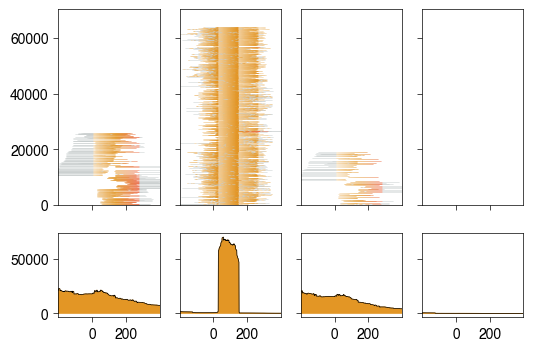

In [12]:
height_ratio = (7,3)

fix, axs=plt.subplots(figsize=(6,4),ncols=4,nrows=2,sharey='row', sharex=True, height_ratios=height_ratio)
for i in [0,2,3,1]: # do 1 last to set the max-y automatically
    hashed = hash_reads(tohash_Tn5spike[i][0], substrings_dict)
    ax = axs[0, i]
    plot_hashing(hashed, heightweight = 150/tohash_Tn5spike[i][1], ax=ax, skip=20, lw=0.4)
    ax.set_xlim(-200,400)
    ax.set_xticks((0,200))


    ax = axs[1,i]
    coverage = 150 * coverage_Tn5spike[i][1] # 1 means the normalized version, 0 means raw
    coverage_x = np.arange(coverage.size)-227
    ax.plot(coverage_x, coverage, color='k',lw=0.5)
    ax.fill_between(coverage_x, coverage, color=drtpalette[2])

    ax.set_xticks((0,200))
plt.savefig("Fig1B.pdf", transparent=True)

# Fig S2A

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


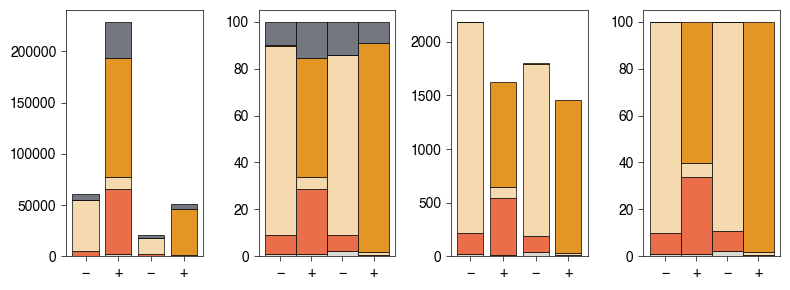

In [14]:
fig, axs = plt.subplots(figsize=(8,3), ncols=4)
bottom = np.zeros(4)

conditions = {'coli': coli, 'cc': cc, 'plasmid':plas-cc, 't5':t5, 'spike':spike }
colors = {'coli': greypalette[3],'cc': drtpalette[1], 'plasmid':drtpalette[3], 't5':drtpalette[2], 'spike':greypalette[0] }


order = ['coli', 'cc', 'plasmid', 't5', 'spike']

for i in range(len(order)):
    condition = order[i]
    plot = conditions[condition]
    color = colors[condition]
    axs[0].bar(np.arange(4),plot,bottom=bottom,color=color)
    bottom+=plot

bottom = np.zeros(4)
for i in range(len(order)):
    condition = order[i]
    plot = (conditions[condition] / (coli+cc+(plas-cc)+t5+spike)) * 100
    color = colors[condition]
    axs[1].bar(np.arange(4),plot,bottom=bottom,color=color,width=1)
    bottom+=plot

bottom = np.zeros(4)
volume = np.array([4.1,3.4,3.4,6.8])
for i in range(len(order)-1): # exclude spike
    condition = order[i]
    plot = conditions[condition] / spike / volume * 1000
    color = colors[condition]
    axs[2].bar(np.arange(4),plot,bottom=bottom,color=color)
    bottom+=plot

bottom = np.zeros(4)
for i in range(len(order)-1):
    condition = order[i]
    plot = (conditions[condition] / (coli+cc+(plas-cc)+t5)) * 100
    color = colors[condition]
    axs[3].bar(np.arange(4),plot,bottom=bottom,color=color,width=1)
    bottom+=plot

for i in range(4):
    axs[i].set_xticks(np.arange(4), labels=['−','+']*2)
plt.tight_layout()
plt.savefig("FigS2A.pdf", transparent=True)

# Figure 1F

In [15]:
tohash_R2 = {}
coli = np.zeros(8)
t5 = np.zeros(8)
plas = np.zeros(8)
cc = np.zeros(8)
unmapped = np.zeros(8)
spike = np.zeros(8)

for i in range(8):
    reads_to_hash = []
    reads_to_hash_strands = []
    pysam.sort("-o", "tmp.bam", f'ssDNA_20240706/sam/D{i+1}.sam')
    pysam.index("tmp.bam")
    samfile = pysam.AlignmentFile('tmp.bam', 'rb')

    refs = samfile.references
    unmapped[i] = samfile.unmapped
    for j in range(4):
        ref = refs[j]
        [t5,plas,coli,spike][j][i] = samfile.count(contig = ref)
    cc[i] = samfile.count(contig = refs[1], start=256, end=376) #20bp in middle of template


    for read in samfile.fetch('pLG128'): # fetch reads mapping ncRNA
        readseq = read.query_sequence
        reads_to_hash.append(readseq)
        reads_to_hash_strands.append(read.is_reverse) #flipped from the R1 data
    spike_reads = samfile.count('spike')
    volume = [4.1,4.1,3.4,3.4,3.4,3.4,6.8,6.8][i]
    normalization = spike_reads * volume / 1000

    tohash_R2[i] = (reads_to_hash, reads_to_hash_strands, normalization)


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


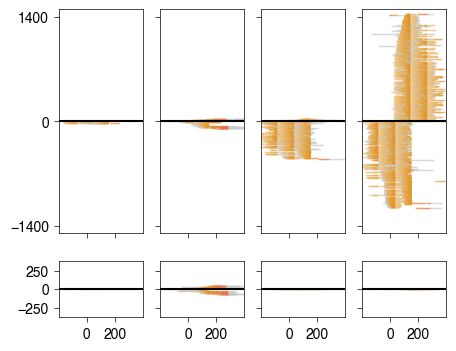

In [16]:
height_ratio = (8,2)
ylim=1500
fix, axs=plt.subplots(figsize=(5,4),ncols=4,nrows=2,sharey='row', sharex=True,height_ratios=height_ratio)
for i in range(8):
    hashed = hash_reads(tohash_R2[i][0], substrings_dict)
    ax = axs[i//4, i%4]
    plot_hashing(hashed, strands = tohash_R2[i][1], heightweight = 4/tohash_R2[i][2], ax=ax, skip=4)
    ax.set_xlim(-200,400)
    if i//4:
        ax.set_ylim(-ylim * height_ratio[1]/height_ratio[0], ylim * height_ratio[1]/height_ratio[0])
    else:
        ax.set_ylim(-ylim , ylim)
        ax.set_yticks((-ylim+100,0,ylim-100))
    ax.set_xticks((0,200))
plt.savefig("Fig1F.pdf", transparent=True)

# Figure S2H

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


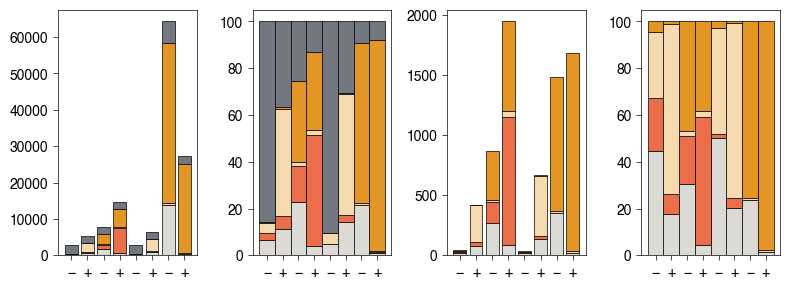

In [17]:
fig, axs = plt.subplots(figsize=(8,3), ncols=4)
bottom = np.zeros(8)

conditions = {'coli': coli, 'cc': cc, 'plasmid':plas-cc, 't5':t5, 'spike':spike }
colors = {'coli': greypalette[3],'cc': drtpalette[1], 'plasmid':drtpalette[3], 't5':drtpalette[2], 'spike':greypalette[0] }


order = ['coli', 'cc', 'plasmid', 't5', 'spike']

for i in range(len(order)):
    condition = order[i]
    plot = conditions[condition]
    color = colors[condition]
    axs[0].bar(np.arange(8),plot,bottom=bottom,color=color)
    bottom+=plot

bottom = np.zeros(8)
for i in range(len(order)):
    condition = order[i]
    plot = (conditions[condition] / (coli+cc+(plas-cc)+t5+spike)) * 100
    color = colors[condition]
    axs[1].bar(np.arange(8),plot,bottom=bottom,color=color,width=1)
    bottom+=plot

bottom = np.zeros(8)
volume = np.array([4.1,4.1,3.4,3.4,3.4,3.4,6.8,6.8])
for i in range(len(order)-1): # exclude spike
    condition = order[i]
    plot = conditions[condition] / spike / volume * 1000
    color = colors[condition]
    axs[2].bar(np.arange(8),plot,bottom=bottom,color=color)
    bottom+=plot

bottom = np.zeros(8)
for i in range(len(order)-1):
    condition = order[i]
    plot = (conditions[condition] / (coli+cc+(plas-cc)+t5)) * 100
    color = colors[condition]
    axs[3].bar(np.arange(8),plot,bottom=bottom,color=color,width=1)
    bottom+=plot

for i in range(4):
    axs[i].set_xticks(np.arange(8), labels=['−','+']*4)
plt.tight_layout()
plt.savefig("FigS2H.pdf", transparent=True)

# Figure 1G

In [18]:
has_jump_plus = np.zeros(8)
has_jump_minus = np.zeros(8)
template_plus = np.zeros(8)
template_minus = np.zeros(8)
for i in range(8):
    strands = tohash_R2[i][1]
    hashed = hash_reads(tohash_R2[i][0], substrings_dict)
    weight = tohash_R2[i][2] / 10

    for j, hash in enumerate(hashed):
        jump = any(h in hash for h in [544,545,546,547,548,549,550])
        template_mapping = any(h in hash for h in list(range(30,150)))
        if strands[j]:
            has_jump_plus[i]+=jump / weight 
            template_plus[i] += template_mapping / weight 
        else:
            has_jump_minus[i]+=jump / weight 
            template_minus[i] += template_mapping / weight 
    

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


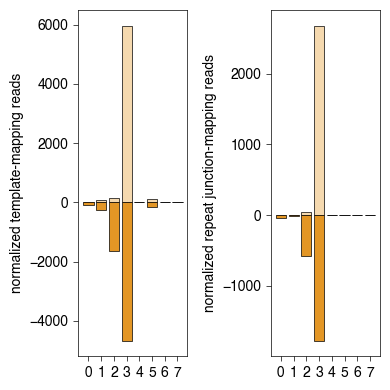

In [19]:
fix, axs=plt.subplots(figsize=(4,4),ncols=2,sharey=False)
axs[0].bar(np.arange(8), template_plus, color=drtpalette[3])
axs[0].bar(np.arange(8), template_minus * -1, color=drtpalette[2])
axs[0].set_ylabel('normalized template-mapping reads')
axs[1].bar(np.arange(8), has_jump_plus, color=drtpalette[3])
axs[1].bar(np.arange(8), has_jump_minus * -1, color=drtpalette[2])
axs[1].set_ylabel('normalized repeat junction-mapping reads')
axs[0].set_xticks(np.arange(8))
axs[1].set_xticks(np.arange(8))
plt.tight_layout()
plt.savefig("Fig1G.pdf", transparent=True)